In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm
import keras
from keras import layers
import scipy.optimize

tf.random.set_seed(2727)
np.random.seed(2727)

c:\Users\jigna\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Heat Equation with Dirichlet boundary conditions on $[0,T]\times[0,c]$:

\begin{align}
\partial_t u(t,x) &= \partial^2_{xx}u(t,x) \\
u(0,x) &= \varphi(x)\\
u(t,0) &= 0\\
u(t,c) &= 0 
\end{align}

Here time-space is modeled by $(t,x)\in[0,T]\times[0,c]$, thus $u\colon[0,T]\times[0,c]\to \R$


In [2]:
class Network:
    def __init__(self, input_dim) -> None:
        self.input_dim = input_dim

    def build(self):
        nn = keras.Sequential(
        [
            layers.Input(shape=(self.input_dim,)),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(32, activation="tanh", kernel_initializer='he_normal', bias_initializer='zeros'),
            layers.Dense(1, kernel_initializer='he_normal', use_bias=False),
        ])
        return nn


In [3]:
class HeatModel:
    # 1D Heat equation PINN-solver. It contains its own nn.
    def __init__(self):

        self.model = Network(2).build()
    
    def init_condition(self, data):
        n = data.shape[0]
        return tf.reshape(data[...,1]**2 * (2-data[...,1]), shape=(n,1))
    
    ##################### LOSS METHODS ###########################

    def pde_loss(self, data):

        # Error given by the PDE over data.
        
        with tf.GradientTape() as tape2:
            tape2.watch(data)
            with tf.GradientTape() as tape1:
                tape1.watch(data)
                u = self.model(data)
            u_z = tape1.batch_jacobian(u, data)
        u_zz = tape2.batch_jacobian(u_z, data)
        u_t = u_z[...,0,0]
        u_xx = u_zz[...,0,1,1]
        return tf.reduce_mean(tf.math.square(u_t - u_xx))

    def boundary_loss(self, data_init, data_left, data_right):
        l1 = tf.reduce_mean(tf.math.square(self.model(data_left)))
        l2 = tf.reduce_mean(tf.math.square(self.model(data_right)))
        l3 = tf.reduce_mean(tf.math.square(self.model(data_init) - self.init_condition(data_init)))
        return l1 + l2 + l3
    
    def total_loss(self, data_int, data_init, data_left, data_right):
        #self.pde_loss(data_int) + 
        return self.boundary_loss(data_init, data_left, data_right) + self.pde_loss(data_int)
    ##################### TRAINING METHODS ###########################
    
    @tf.function
    def gradients(self, data_int, data_init, data_left, data_right):
        with tf.GradientTape() as tape:
            tape.watch(self.model.trainable_variables)
            target = self.total_loss(data_int, data_init, data_left, data_right)
        return target, tape.gradient(target, self.model.trainable_variables)

    def fit_SGD(self, data_int, data_init, data_left, data_right):
        n = data_int.shape[0]
        l = []
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        b = 64
        for _ in tqdm(tf.range(50)):
            for j in tqdm(tf.range(n)):
                i = np.random.randint(n - b)
                target, gradients = self.gradients(data_int[i:i+b], data_init[i:i+b], data_left[i:i+b], data_right[i:i+b])
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            l.append(target)
        return l
    
    def fit(self, data_int, data_init, data_left, data_right):
        n = data_int.shape[0]
        l = []
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        b = 32
        for epoch in tf.range(60):
            for i in tqdm(tf.range(n - b)):
                i = tf.cast(i, tf.int32)
                target, gradients = self.gradients(data_int[i:i+b], data_init[i:i+b], data_left[i:i+b], data_right[i:i+b])
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            l.append(target)
        return l

In [4]:
heat_model = HeatModel()

In [5]:
# batch_size
n = 1000
# Interior data t \in [0,2], x \in [0,2]
data_int = tf.Variable(np.random.rand(n,2) * 2, trainable=False, dtype="float32")
# t=0 data
data_init = (np.random.rand(n,2) * 2)
data_init[..., 0] = 0
data_init = tf.constant(data_init, dtype="float32")
# x = 0 data
data_left = np.random.rand(n,2) * 2
data_left[..., 1] = 0
data_left = tf.constant(data_left, dtype="float32")
# x = 2 data
data_right = np.random.rand(n,2) * 2
data_right[..., 1] = 2
data_right = tf.constant(data_right, dtype="float32")


In [6]:
l = heat_model.fit(data_int, data_init, data_left, data_right)

100%|██████████| 968/968 [00:12<00:00, 80.60it/s]

epoch n°: 1



100%|██████████| 968/968 [00:10<00:00, 95.05it/s]

epoch n°: 2



100%|██████████| 968/968 [00:10<00:00, 91.84it/s]

epoch n°: 3



100%|██████████| 968/968 [00:10<00:00, 92.77it/s]

epoch n°: 4



100%|██████████| 968/968 [00:10<00:00, 96.01it/s] 

epoch n°: 5



100%|██████████| 968/968 [00:09<00:00, 98.10it/s] 

epoch n°: 6



100%|██████████| 968/968 [00:09<00:00, 97.94it/s] 

epoch n°: 7



100%|██████████| 968/968 [00:09<00:00, 98.61it/s] 

epoch n°: 8



100%|██████████| 968/968 [00:09<00:00, 98.27it/s] 

epoch n°: 9



100%|██████████| 968/968 [00:09<00:00, 98.09it/s]

epoch n°: 11



100%|██████████| 968/968 [00:10<00:00, 93.85it/s]

epoch n°: 12



100%|██████████| 968/968 [00:10<00:00, 95.74it/s]

epoch n°: 13



100%|██████████| 968/968 [00:10<00:00, 92.73it/s]

epoch n°: 14



100%|██████████| 968/968 [00:10<00:00, 93.53it/s]

epoch n°: 15



100%|██████████| 968/968 [00:10<00:00, 89.45it/s]

epoch n°: 16



100%|██████████| 968/968 [00:10<00:00, 92.34it/s]

epoch n°: 17



100%|██████████| 968/968 [00:10<00:00, 88.48it/s]

epoch n°: 18



100%|██████████| 968/968 [00:10<00:00, 91.45it/s]

epoch n°: 19



100%|██████████| 968/968 [00:10<00:00, 89.62it/s]

epoch n°: 21



100%|██████████| 968/968 [00:10<00:00, 94.78it/s]

epoch n°: 22



100%|██████████| 968/968 [00:10<00:00, 90.74it/s]

epoch n°: 23



100%|██████████| 968/968 [00:10<00:00, 95.16it/s] 

epoch n°: 24



100%|██████████| 968/968 [00:09<00:00, 102.83it/s]

epoch n°: 25



100%|██████████| 968/968 [00:09<00:00, 103.02it/s]

epoch n°: 26



100%|██████████| 968/968 [00:09<00:00, 103.10it/s]

epoch n°: 27



100%|██████████| 968/968 [00:09<00:00, 103.37it/s]

epoch n°: 28



100%|██████████| 968/968 [00:09<00:00, 102.95it/s]

epoch n°: 29



100%|██████████| 968/968 [00:09<00:00, 103.28it/s]

epoch n°: 31



100%|██████████| 968/968 [00:09<00:00, 103.44it/s]

epoch n°: 32



100%|██████████| 968/968 [00:09<00:00, 102.86it/s]

epoch n°: 33



100%|██████████| 968/968 [00:09<00:00, 103.28it/s]

epoch n°: 34



100%|██████████| 968/968 [00:10<00:00, 94.84it/s] 

epoch n°: 35



100%|██████████| 968/968 [00:10<00:00, 93.02it/s]

epoch n°: 36



100%|██████████| 968/968 [00:10<00:00, 94.80it/s]


epoch n°: 37


100%|██████████| 968/968 [00:10<00:00, 94.91it/s]

epoch n°: 38



100%|██████████| 968/968 [00:10<00:00, 95.13it/s]

epoch n°: 39



100%|██████████| 968/968 [00:10<00:00, 95.83it/s]

epoch n°: 41



100%|██████████| 968/968 [00:10<00:00, 95.02it/s]

epoch n°: 42



100%|██████████| 968/968 [00:10<00:00, 95.79it/s]

epoch n°: 43



100%|██████████| 968/968 [00:10<00:00, 95.34it/s]

epoch n°: 44



100%|██████████| 968/968 [00:10<00:00, 95.83it/s]

epoch n°: 45



100%|██████████| 968/968 [00:10<00:00, 96.28it/s]

epoch n°: 46



100%|██████████| 968/968 [00:10<00:00, 96.09it/s]

epoch n°: 47



100%|██████████| 968/968 [00:10<00:00, 96.32it/s]

epoch n°: 48



100%|██████████| 968/968 [00:10<00:00, 96.41it/s]

epoch n°: 49



100%|██████████| 968/968 [00:10<00:00, 96.47it/s]

epoch n°: 51



100%|██████████| 968/968 [00:10<00:00, 95.25it/s]

epoch n°: 52



100%|██████████| 968/968 [00:10<00:00, 96.68it/s]

epoch n°: 53



100%|██████████| 968/968 [00:10<00:00, 96.21it/s]

epoch n°: 54



100%|██████████| 968/968 [00:10<00:00, 96.46it/s]

epoch n°: 55



100%|██████████| 968/968 [00:09<00:00, 96.83it/s]

epoch n°: 56



100%|██████████| 968/968 [00:10<00:00, 96.64it/s]

epoch n°: 57



100%|██████████| 968/968 [00:09<00:00, 96.92it/s]

epoch n°: 58



100%|██████████| 968/968 [00:09<00:00, 96.86it/s]

epoch n°: 59



100%|██████████| 968/968 [00:10<00:00, 96.79it/s]


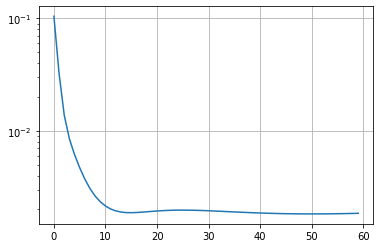

In [11]:
plt.plot(l)
plt.grid()
plt.yscale("log")

In [22]:
z = np.arange(0,2 + 0.01,0.01)
a0 = np.array([[0.0, x] for x in z])
a1 = np.array([[0.01, x] for x in z])
a2 = np.array([[0.05, x] for x in z])
a3 = np.array([[0.1, x] for x in z])
a4 = np.array([[0.15, x] for x in z])
a5 = np.array([[0.2, x] for x in z])

In [23]:
b0 = heat_model.model(a0)[...,0].numpy()
b1 = heat_model.model(a1)[...,0].numpy()
b2 = heat_model.model(a2)[...,0].numpy()
b3 = heat_model.model(a3)[...,0].numpy()
b4 = heat_model.model(a4)[...,0].numpy()
b5 = heat_model.model(a5)[...,0].numpy()



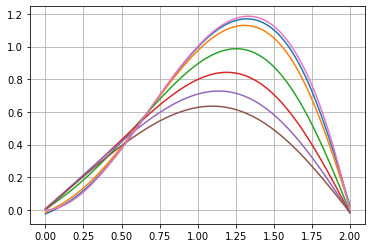

In [24]:
plt.plot(z, b0)
plt.plot(z, b1)
plt.plot(z, b2)
plt.plot(z, b3)
plt.plot(z, b4)
plt.plot(z, b5)
plt.plot(z, heat_model.init_condition(a0))
plt.grid()